$$
a+b = c
$$
Inline equation: $ a+b = c $

### Curve-fitting in a single CSTR reactor model

reference: SciPy ode.integrate module https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html
optimisation: Scipy.optimize.minimize_scalar https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html#scipy.optimize.minimize_scalar

#### Mass balance for a single CSTR:

$$ 
\frac{\partial{C}}{\partial{t}} = F_{in} - F_{out} = F_{in} - \frac{q}{V}C = \frac{q}{V}(f(t)C_{in}-C)
$$
Inlet concentration changes as a square wave: 
$$
\begin {cases}
C_{in} = 0,      t<t_{start}, t>t_{end} \\
C_{in} = C_{in},      t_{end}<t<t_{start}
\end {cases}
$$
Objective function: sum of squares:
$$
Error = \sum{(C_{exp}-C_{model})^2}
$$
Fitted paremeters are:$ q, C_{in}, t_{end}, t_{start} $


In [15]:
import numpy as np
import matplotlib.pyplot as p
import scipy
from scipy.interpolate import interp1d
from scipy.stats import norm
%matplotlib notebook

#### This defines initial conditions:

In [2]:
time_start = 40 #integration start time
time_stop = 200 # integration stop time
inj_start = 57 #injection start time
inj_stop = 65 #injection stop time

#Initial conditions:
c0 = 0 # [mol/s]
V = 1 #[ml?]
c_in = 3.15e-8 #[mol/s]

#### Defining ODE for CSTR model, and feed profile:

In [3]:
#function that defines right side of ODE equation:
def cstr_ode(t, c, c_in, q, V, inj_start, inj_stop):
    dcdt = q/V*(feed(t, inj_start, inj_stop)*c_in - c)
    return dcdt

#function that defines injection:
def feed(t, inj_start, inj_stop):
     if t<inj_start:
        return 0
     elif t>inj_stop:
        return 0
     else:
        return 1

#### Function for solving ODE model, and to return the transient concentration profile:

In [4]:
#### Function for solving ODE model, and to return the transient concentration profile:#Function that takes parameter to be optimised and returns 
def cstr(q, c_in, inj_start, inj_stop):
    #calling an integration function and assign the output to sol object
    fun = lambda t, c: cstr_ode(t, c, c_in, q, V, inj_start, inj_stop)
    sol = scipy.integrate.solve_ivp(fun, [time_start,time_stop], [c0], rtol = 1e-10, atol = 1e-10, max_step = 0.1)
    t = sol.t 
    c = sol.y[0] # output is in multidimensional array, getting 1st dimension
    c = interp1d(t, c) #interpolation to sync with experimental sampling 
    return c, t


In [5]:
fun = lambda t, c: cstr_ode(t, c, c_in, q, V, inj_start, inj_stop)
def fun(t,c):
    return cstr_ode(t, c, c_in, q, V, inj_start, inj_stop)

#### Objective function:

In [6]:
#### Objective function:
def obj_fun(x):
    q = x[0]
    c_in = x[1]
    inj_start = x[2]
    inj_stop = x[3]
    model_data, model_time = cstr(q, c_in, inj_start, inj_stop)
    obj = np.sum((exp_data-model_data(exp_time))**2, axis = 0)
    return obj

#### Importing and plotting experimental data:

In [16]:
#import:
data = []
f = open('data.txt')
for line in f:
    data.append(float(line.replace('E', 'e')))
time = []
f = open('time.txt')
for line in f:
    time.append(float(line))
print(data[4])
calibration = 690000 #Hand-chosen number, need to find from experiment

exp_data = np.array(data)/calibration
exp_time = np.array(time)

#Selecting the needed experimental data
inlet = exp_time>time_start
exp_time = exp_time[inlet]
exp_data = exp_data[inlet]
stop = exp_time<time_stop
exp_time = exp_time[stop]
exp_data = exp_data[stop]

p.plot(exp_time, exp_data)
p.title('Experimental data')
p.xlabel('Time, [s]')
p.ylabel('Molar Flow, [mol/s]')

4.81637e-07


<IPython.core.display.Javascript object>

Text(0, 0.5, 'Molar Flow, [mol/s]')

#### Sample of simulation (q = 1) before fitting, random noise is added:

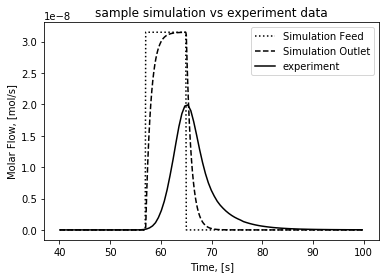

In [17]:
set_q = 1
set_c_in = c_in
y_data, x_data = cstr(set_q, c_in, inj_start, inj_stop)
y_data = y_data(x_data)
feed_data = list(range(len(x_data)))
for i, j in enumerate(x_data):
    feed_data[i] = feed(j, inj_start, inj_stop)*3.15e-8
p.plot(x_data, feed_data, 'k:', label = 'Simulation Feed')
p.plot(x_data, y_data, 'k--', label = 'Simulation Outlet')
p.plot(exp_time, exp_data, 'k', label = 'experiment')
p.title('sample simulation vs experiment data')
p.xlabel('Time, [s]')
p.ylabel('Molar Flow, [mol/s]')
p.legend()

#### Multivariate optimisation by finding minimum of the objective function:
takes appr. 3-7 min to complete

In [14]:
res = scipy.optimize.minimize(obj_fun, [0.5, c_in, inj_start, inj_stop], method = 'Nelder-Mead')
q_found = res.x[0]
c_in_found = res.x[1]
inj_start_found = res.x[2]
inj_stop_found = res.x[3]
print(f'Optimal parameters are:')
print(f'q = {q_found}')
print(f'c = {c_in_found}')
print(f'injection start = {inj_start_found}')
print(f'injection stop = {inj_stop_found}')
res

Optimal parameters are:
q = 0.2803781618530502
c = 2.7572376330702062e-08
injection start = 60.49109998833066
injection stop = 65.8910851135146


 final_simplex: (array([[2.80378162e-01, 2.75723763e-08, 6.04911000e+01, 6.58910851e+01],
       [2.80434115e-01, 2.75728005e-08, 6.04911015e+01, 6.58910293e+01],
       [2.80370712e-01, 2.75726637e-08, 6.04910183e+01, 6.58910728e+01],
       [2.80446037e-01, 2.75729518e-08, 6.04910084e+01, 6.58910631e+01],
       [2.80418031e-01, 2.75729195e-08, 6.04910611e+01, 6.58910192e+01]]), array([3.53152960e-17, 3.53163637e-17, 3.53168587e-17, 3.53169055e-17,
       3.53172406e-17]))
           fun: 3.531529595614525e-17
       message: 'Optimization terminated successfully.'
          nfev: 394
           nit: 221
        status: 0
       success: True
             x: array([2.80378162e-01, 2.75723763e-08, 6.04911000e+01, 6.58910851e+01])

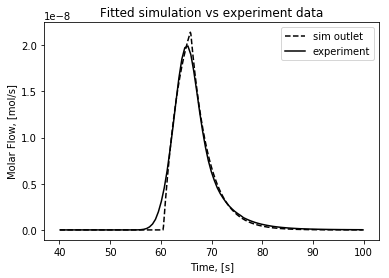

In [16]:
model_data, model_time = cstr(q_found, c_in_found, inj_start_found, inj_stop_found)
model_data = model_data(model_time)
#p.plot(x_data, feed_data, label = 'sim inlet')
p.plot(model_time, model_data, 'k--', label = 'sim outlet')
p.plot(exp_time, exp_data, 'k', label = 'experiment')
p.title('Fitted simulation vs experiment data')
p.xlabel('Time, [s]')
p.ylabel('Molar Flow, [mol/s]')
p.legend()